# Sparse vectors analysis

The present notebook constitutes an attempt to analyse wether converting dense embedding vectors to sparse vectors will affect the performance of the Author Name Disambiguation task. 

Basically, what we need to find is the threshold bollow which vector elements can be set to 0. We will perform the analysis in one large author block from the Pubmed sub-dataset.

In [1]:
import sys

sys.path.append('../')

import torch, copy, numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from s2and.data import ANDData
from s2and_ext.my_utils import load_dataset, load_signatures
from torch.nn.functional import cosine_similarity

Initially, we load pubmed dataset and from there we extract the largest block of signatures.

In [3]:
dataset = load_dataset('pubmed')
signatures = load_signatures('pubmed')
blocks = dataset.get_blocks()

biggest_block_name = [k for k, _ in sorted(blocks.items(), key=lambda item: len(item[1]))][-1]

print(f'Biggest block name: {biggest_block_name}')
print(f'Biggest block size: {len(blocks[biggest_block_name])}')

block_signatures = blocks[biggest_block_name]

Loaded dataset from pickle...
Biggest block name: r agarwal
Biggest block size: 283


For the extracted signatures block we want to calculate cosine similarities between every possible combination of documents. This will be our golden distances. Afterwards, we convert dense vectors to sparse using a certain threshold and we calculate the distances again. We compare the results with the golden distances and we extract the average error. Repeating this process for various thresholds yields the following figure:

In [4]:
def get_embedding_tuples(block_signatures, signature_dict):
    """Get all possible embeddings tuples for author block"""
    tuples = []
    for signature_row in block_signatures:
        if signature_row not in signatures: continue
        embedding_row = torch.Tensor(signatures[signature_row]['paperVector'])
        for signature_column in block_signatures:
            if signature_column not in signatures: continue
            embedding_column = torch.Tensor(signatures[signature_column]['paperVector'])
            tuples.append((embedding_row, embedding_column))
    return tuples

def calculate_similarities(embedding_tuples):
    """Given list of embedding tuples, calculate cosine similarity"""
    return np.asarray([cosine_similarity(emb1, emb2, dim=0).item() for emb1, emb2 in embedding_tuples])

def make_sparse(vector, threshold):
    """"Set every element of the input vector with value lower than threshold to zero"""
    vector = copy.deepcopy(vector)
    vector[torch.abs(vector) < threshold] = 0
    return vector

def make_tuples_sparse(embedding_tuples, threshold):
    """"Make embeddingsin tuples sparse"""
    return [(make_sparse(emb1, threshold), make_sparse(emb2, threshold)) for emb1, emb2 in embedding_tuples]

In [5]:
thresholds = np.arange(0, 0.3, 0.005)
original_tuples = get_embedding_tuples(block_signatures=block_signatures, signature_dict=signatures)
original_similarities = calculate_similarities(original_tuples)

errors = []
for threshold in tqdm(thresholds):
    sparse_tuples = make_tuples_sparse(original_tuples, threshold)
    sparse_similarities = calculate_similarities(sparse_tuples)
    errors.append(np.abs(original_similarities - sparse_similarities).mean())


100%|██████████| 60/60 [06:03<00:00,  6.05s/it]


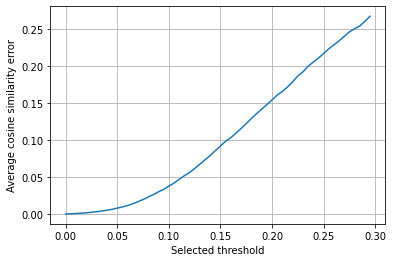

In [6]:
plt.figure()
plt.plot(thresholds, errors)
plt.xlabel('Selected threshold')
plt.ylabel('Average cosine similarity error')
plt.grid('minor')
plt.savefig('results/sparse_error', dpi=500)
plt.show()

Apart from the error that is introduced into cosine similarity by converting dense vectors to sparse, we also need to check the dimensionality reduction that we achieve for the various thresholds. Again, we calculate the average number of dimensions for the vectors of the selected block for various threshold values. The following figure is retrieved:

In [7]:
def get_block_embeddings(block_signatures, signature_dict):
    """Get list of block embeddings"""
    embeddings = []
    for signature_row in block_signatures:
        if signature_row not in signatures: continue
        embeddings.append(torch.Tensor(signatures[signature_row]['paperVector']))
    return embeddings

def count_valid_dimensions(embeddings):
    """Calculate average number of non-zero dimensions"""
    return np.mean([embedding.shape[0] - (embedding == 0).sum().item() for embedding in embeddings])

In [8]:
original_embeddings = get_block_embeddings(block_signatures=block_signatures, signature_dict=signatures)
original_dimensions = count_valid_dimensions(original_embeddings)

dimensions = []
for threshold in tqdm(thresholds):
    sparse_embeddings = [make_sparse(embedding, threshold) for embedding in original_embeddings]
    dimensions.append(count_valid_dimensions(sparse_embeddings))

100%|██████████| 60/60 [00:00<00:00, 86.47it/s]


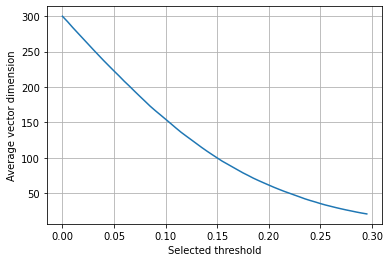

In [9]:
plt.figure()
plt.plot(thresholds, dimensions)
plt.xlabel('Selected threshold')
plt.ylabel('Average vector dimension')
plt.grid('minor')
plt.savefig('results/sparse_dimensions', dpi=500)
plt.show()